In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('modecraft_online_retail.csv')

<ipython-input-4-3490fb982aea>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('modecraft_online_retail.csv')


In [ ]:
# Data Cleaning
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%y %H:%M')
df = df.dropna()
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [ ]:
# Feature Engineering
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5,6])
df['Quarter'] = df['InvoiceDate'].dt.quarter

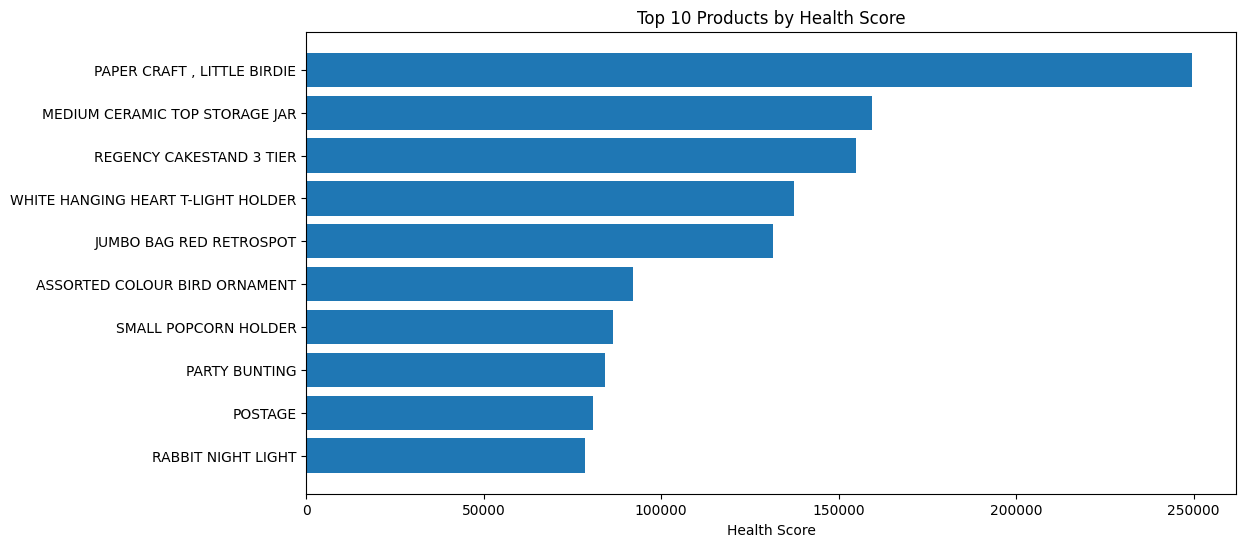

In [ ]:
# Product Health Score
product_quantity = df.groupby('StockCode')['Quantity'].sum().reset_index()
product_revenue = df.groupby('StockCode')['Revenue'].sum().reset_index()
product_summary = pd.merge(product_quantity, product_revenue, on='StockCode')
product_description = df[['StockCode', 'Description']].drop_duplicates('StockCode')
product_summary = pd.merge(product_summary, product_description, on='StockCode')
product_summary['HealthScore'] = product_summary['Revenue'] + product_summary['Quantity']
product_summary['Rank'] = product_summary['HealthScore'].rank(ascending=False)
product_summary = product_summary.sort_values('HealthScore', ascending=False)

# Top 10 Products by HealthScore
plt.figure(figsize=(12,6))
plt.barh(product_summary.head(10)['Description'], product_summary.head(10)['HealthScore'])
plt.xlabel('Health Score')
plt.title('Top 10 Products by Health Score')
plt.gca().invert_yaxis()
plt.show()

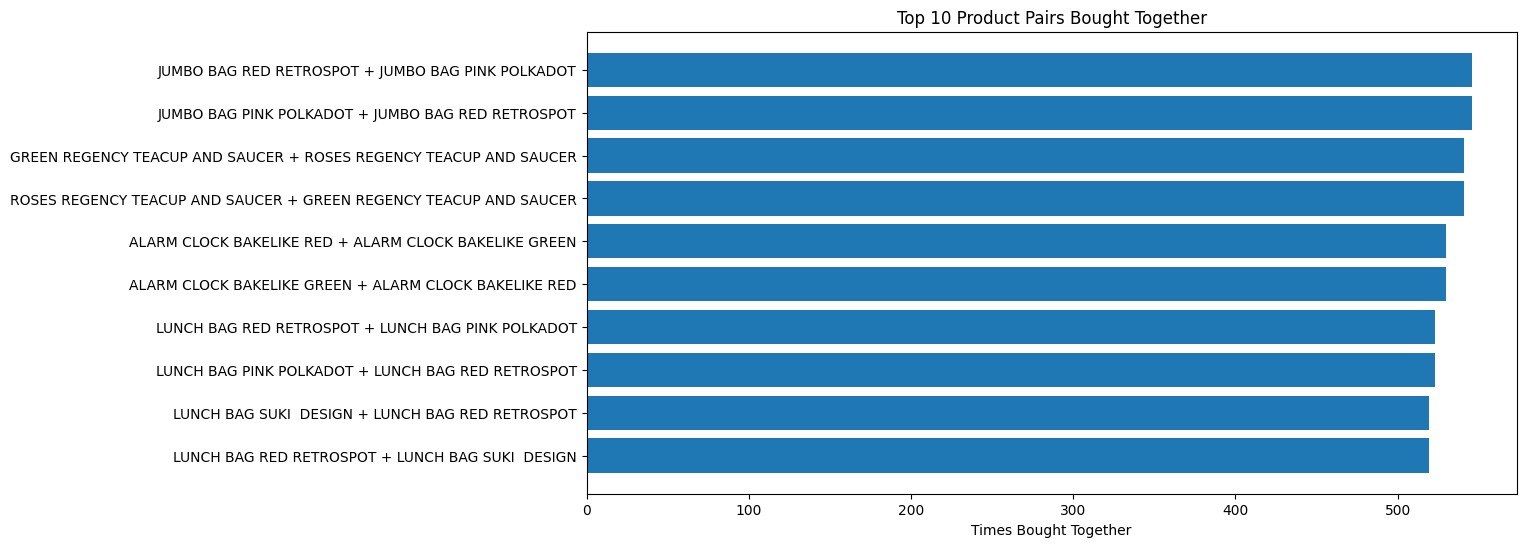

In [ ]:
# Market Basket Analysis
popular_products = df['StockCode'].value_counts()
popular_products = popular_products[popular_products >= 50].index
df_filtered = df[df['StockCode'].isin(popular_products)]

basket_raw = df_filtered[['InvoiceNo', 'StockCode', 'Quantity']]
basket = basket_raw.pivot_table(index='InvoiceNo', columns='StockCode', values='Quantity', fill_value=0)
basket = basket.gt(0).astype(int)

co_occurrence = basket.T.dot(basket)
for col in co_occurrence.columns:
    co_occurrence.loc[col, col] = 0

co_occurrence = co_occurrence.reset_index()
co_occurrence_melted = co_occurrence.melt(id_vars='StockCode', var_name='Other_Product', value_name='Bought_Together')

top_pairs = co_occurrence_melted[co_occurrence_melted['Bought_Together'] > 10].sort_values('Bought_Together', ascending=False)

descriptions = df[['StockCode', 'Description']].drop_duplicates('StockCode')
descriptions_other = descriptions.rename(columns={'StockCode': 'Other_Product', 'Description': 'Description_B'})

top_pairs = top_pairs.merge(descriptions, on='StockCode')
top_pairs = top_pairs.rename(columns={'Description': 'Description_A'})
top_pairs = top_pairs.merge(descriptions_other, on='Other_Product')

top_pairs_final = top_pairs[['Description_A', 'Description_B', 'Bought_Together']]

# Top 10 Product Pairs Bought Together
plt.figure(figsize=(12,6))
plt.barh(top_pairs_final.head(10)['Description_A'] + ' + ' + top_pairs_final.head(10)['Description_B'],
         top_pairs_final.head(10)['Bought_Together'])
plt.xlabel('Times Bought Together')
plt.title('Top 10 Product Pairs Bought Together')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Outputs

from IPython.display import display
display(df.head())
display(product_summary[['StockCode', 'Description', 'Quantity', 'Revenue', 'HealthScore', 'Rank']].head(10))
display(top_pairs_final.head(10))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,DayOfWeek,Weekend,Quarter
0,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,2,False,4
1,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50,2010,12,1,8,2,False,4
2,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2,False,4
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,2,False,4
4,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30,2010,12,1,8,2,False,4


,StockCode,Description,Quantity,Revenue,HealthScore,Rank
2399,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,168469.60,249464.60,1.0
1997,23166,MEDIUM CERAMIC TOP STORAGE JAR,77916,81416.73,159332.73,2.0
1288,22423,REGENCY CAKESTAND 3 TIER,12402,142592.95,154994.95,3.0
3233,85123A,WHITE HANGING HEART T-LIGHT HOLDER,36782,100603.50,137385.50,4.0
3219,85099B,JUMBO BAG RED RETROSPOT,46181,85220.78,131401.78,5.0
3059,84879,ASSORTED COLOUR BIRD ORNAMENT,35362,56580.34,91942.34,6.0
1088,22197,SMALL POPCORN HOLDER,49183,37226.43,86409.43,7.0
2593,47566,PARTY BUNTING,15291,68844.33,84135.33,8.0
3664,POST,POSTAGE,3120,77803.96,80923.96,9.0
1919,23084,RABBIT NIGHT LIGHT,27202,51346.20,78548.20,10.0


,Description_A,Description_B,Bought_Together
0,JUMBO BAG RED RETROSPOT,JUMBO BAG PINK POLKADOT,546
1,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,546
2,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,541
3,ROSES REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,541
4,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE GREEN,530
5,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,530
6,LUNCH BAG RED RETROSPOT,LUNCH BAG PINK POLKADOT,523
7,LUNCH BAG PINK POLKADOT,LUNCH BAG RED RETROSPOT,523
8,LUNCH BAG SUKI DESIGN,LUNCH BAG RED RETROSPOT,519
9,LUNCH BAG RED RETROSPOT,LUNCH BAG SUKI DESIGN,519
